In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets
from IPython.display import display
import scipy.linalg
from IPython import display

import pdb
from joblib import Parallel, delayed

In this notebook, we explore the use of rate reduction as a tool for unsupervised segmentation of multivariate and multimodal data. The algorithms and content are based on the following two references:

__Ma, Yi, et al. "Segmentation of multivariate mixed data via lossy data coding and compression." IEEE transactions on pattern analysis and machine intelligence 29.9 (2007): 1546-1562.__

__Yang, Allen Y., et al. "Unsupervised segmentation of natural images via lossy data compression." Computer Vision and Image Understanding 110.2 (2008): 212-225.__

More recently, the use of coding lengths and rate reduction have been discussed in the context of a ''first principles'' based approach to deep learning. This is discussed at length in chapter 16 of the excellent textbook 

__Wright, John, and Yi Ma. High-dimensional data analysis with low-dimensional models: Principles, computation, and applications. Cambridge University Press, 2022.__

Suppose we are given a dataset $\boldsymbol W = [w_1, ..., w_m] \in \mathbb{R}^{n \times m}$. We model the data vectors $w_i \in \mathbb{R}^n$ for $i=1,...,m$ as being drawn from $k$ possibly-degenerate Gaussian distributions. Here, $k$ may be unknown. Our goal is to determine an appropriate estimate for $k$ as well as a partitioning of the data points $w_i$ into the classes $1,...,k$.

The algorithms in the above paper are based on the Gaussian coding length function $L(V)$:

$L({\boldsymbol V}) = \frac{m+n}{2} \log_2 \det \left( I + \frac{n}{\epsilon^2 m} VV^T \right)$,

where ${\boldsymbol V} \in \mathbb{R}^{n \times m}$ is some collection of points which have zero mean, i.e., $\mu=\frac{1}{m}\sum_{i=1}^m v_i = 0$. In the above, $\epsilon$ specifies the error or uncertainty radius around each data point. 

The coding length associated with a particular partitioning of the $m$ data vectors $w_i$ into multiple groups $W_1$,...,$W_k$ is then given by

$L^s({\boldsymbol W_1},...,{\boldsymbol W_k}) = \sum_{i=1}^k L({\boldsymbol W_k}) + \left| {\boldsymbol W_i}\right| \times \left(- \log_2 \left(\frac{\left|W_i\right|}{m}\right) \right)$.

where $|\cdot|$ denotes the number of vectors in $\cdot$. 

In the notebook below, we implement Algorithm 1 from the above paper. 

__Algorithm 1: Pairwise Steepest Descent of Coding Length__

__input:__ data $\boldsymbol W = [ w_1, ..., w_m ]$, distortion $\epsilon>0$.

__initialize:__ $\mathcal{S} = \{S=\{w\} |w\in {\boldsymbol W} \}$

__while__ $\left| \mathcal{S} \right| > 1$: <br>
>Pick distinct sets $S_1, S_2 \in \mathcal{S}$ such that $L^s(S_1 \cup S_2) - L^s (S_1,S_2)$ is minimized <br>
>__if__ the corresponding $L^s(S_1 \cup S_2) - L^s (S_1,S_2)>=0$, __then__ break <br>
>__else__ $\mathcal{S} := ( \mathcal{S} \backslash \{S_1,S_2\}) \cup (\{S_1,S_2\})$

__end while__ <br>

__Output__: $\mathcal{S}$

In [3]:
def codingLength(V,eps):
    # data vectors are columns of V
    n = V.shape[0]
    m = V.shape[1]
    mu = np.mean(V, axis=1)
    Vbar = V-mu.reshape((n, 1))
    eps2 = eps**2
    R = (m+n)/2 * np.log2( np.linalg.det(np.eye(n) + n / (m*eps2) * Vbar@Vbar.T ) ) + (n/2)*np.log2(1+ np.dot(mu,mu)/eps2)
    return R

def groupCodingLength(W, eps):
    #k = len(W)
    m_tot = 0
    for Wi in W:
        m_tot += Wi.shape[1]
    log2mtot = np.log2(m_tot)
    R = 0
    for Wi in W:
        mi = Wi.shape[1]
        R += codingLength(Wi, eps) + mi*(-np.log2(mi)+log2mtot)
    return R

def decreaseInCodingLength(args):
    A = args[0]
    B = args[1] 
    eps = args[2]
    return groupCodingLength([np.hstack((A,B))], eps) - groupCodingLength([A,B], eps)


def pickMinPair(S, eps):
    k = len(S)
    
    idxs = [(i,j) for i in range(k) for j in range(i)]
    pairs = [(S[i[0]], S[i[1]], eps) for i in idxs]
    
    L = Parallel(n_jobs=4)\
    (delayed(decreaseInCodingLength)(args) for args in pairs)
    #L = [decreaseInCodingLength(args) for args in pairs]
    
    imin = np.argmin(L)
    min_L = L[ imin ]
    minPairIndex = idxs[ imin ]
                
    return minPairIndex, min_L
                
            
def pairwiseSteepestDescent(W, eps, opts):
    n = W.shape[0]
    m = W.shape[1]
    S = [W[:,ii].reshape((-1,1)) for ii in range(m)] #initialize with singletons
    count = 0
    
    while len(S) > 1:
        idx, Lij = pickMinPair(S, eps)
        if Lij > 0: #no further (pairwise) reduction of coding length possible
            break
        else:
            # note idx[0] > idx[1], so popping idx[0] first does not affect the index of idx[1] in list S
            S1 = S.pop(idx[0])
            S2 = S.pop(idx[1])
            S.append(np.hstack((S1,S2)))
        count +=1
        
        if count>opts['maxIter']:
            print('terminated prematurely: max iteratations exceeded')
            break
        
    return S

With the above algorithms implemented, we first test the performance on a simple 3D mixture of Gaussian clustering example.
Then we move to a more realistic example.

## Toy example

In [27]:
n = 2

A1 = np.random.randn(n,n)
A2 = np.random.randn(n,n)
A3 = np.random.randn(n,n)

#covariance matrices 
C1 = A1.T@A1
C2 = A2.T@A2
C3 = A3.T@A3

#means
mu1 = np.random.randn(n)
mu2 = np.random.randn(n)
mu3 = np.random.randn(n)

#samples
m1 = 50
m2 = 50
m3 = 50

sample1 = np.random.multivariate_normal(mu1, C1, size=m1).T
sample2 = np.random.multivariate_normal(mu2, C2, size=m2).T
sample3 = np.random.multivariate_normal(mu3, C3, size=m3).T

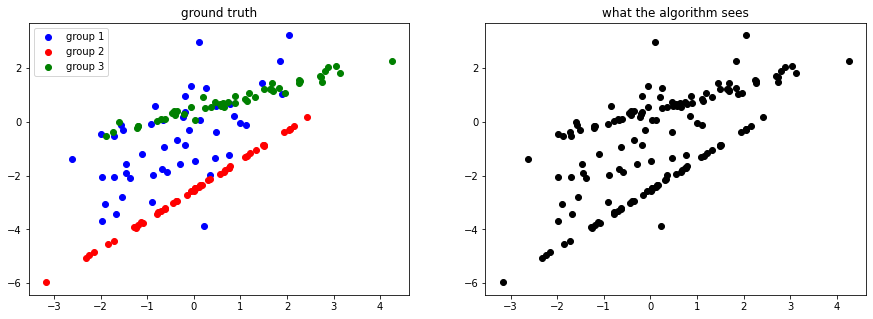

In [28]:
#ground truth
color1 = 'blue'
color2 = 'red'
color3 = 'green'
fig, (ax1, ax2) = plt.subplots(figsize=(15,5), ncols=2)
ax1.scatter(sample1[0,:],sample1[1,:],c=color1, label='group 1')
ax1.scatter(sample2[0,:],sample2[1,:],c=color2, label='group 2')
ax1.scatter(sample3[0,:],sample3[1,:],c=color3, label='group 3')
ax1.set_title('ground truth')
ax1.legend(loc='best')

ax2.scatter(sample1[0,:],sample1[1,:],c='black')
ax2.scatter(sample2[0,:],sample2[1,:],c='black')
ax2.scatter(sample3[0,:],sample3[1,:],c='black')
ax2.set_title('what the algorithm sees')

plt.show()

In [29]:
# algorithm 
Win = np.hstack((sample1,sample2,sample3))

In [30]:
epsilon = 0.1 #essentially a tuning parameter
opts={'maxIter': 1e6}

S = pairwiseSteepestDescent(Win, epsilon, opts)

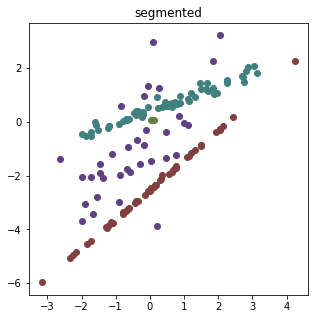

In [31]:
## analyzing the results

#estimated number of groups
k = len(S)

#autogen color scheme
import colorsys
HSV_tuples = [(i*1.0/k, 0.5, 0.5) for i in range(k)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))

fig, ax = plt.subplots(figsize=(5,5))

for i in range(k):
    ax.scatter(S[i][0,:],S[i][1,:],color=RGB_tuples[i])
ax.set_title('segmented')
plt.show()

## Segmentation of an image

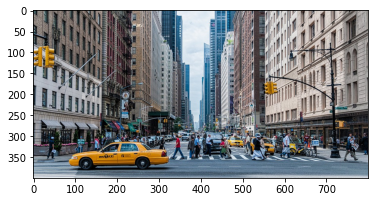

In [5]:
#loading the image
from matplotlib import image
#im = image.imread('8bit.png')
im = image.imread('image.jpg') / 255

# How we scale the image strongly impacts the results. Without the above normalization, the results are incomprehensible.
# Appropriate preprocessing is essential to successful implementation.
# A very useful discussion on preprocessing of images can be found in 
# __Mairal, Julien, Francis Bach, and Jean Ponce. "Sparse modeling for image and vision processing." arXiv preprint arXiv:1411.3230 (2014).__

nrows = im.shape[0]
ncols = im.shape[1]
nchannel = im.shape[2]

plt.imshow(im)
plt.show()

For each pixel in the image, we associate a feature vector generated by a 7-by-7 window around the pixel across each of the 3 channels. Each feature vector therefore lives in high dimensional space. Since the dimensionality is quite large, we follow the above reference (see section 5.2.1) and subsample the pixels/feature vectors and then use PCA to project onto a lower dimension in feature space. These lower dimensional feature vectors are used as input to the segmentation algorithm. 

The unsampled pixels will be grouped with the nearest segment in the feature space. Through this, the entire image is segmented. 

Moreover, experimentally, I have found that tuning the above algorithm is a little difficult for the above image. For reasonable sample sizes (<1000, to have the runtime < 1 day), I get way too many segments. I think that may be because the image is quite complex. To simplify, we will first reduce the image through max pooling.

In [7]:
def extractFeatures(p,im, window_radius):
    # p=(row,col)
    nrows = im.shape[0]
    ncols = im.shape[1]
    nchannel = im.shape[2]
    #hard wired
    window_length = 2*window_radius+1
    feature_dim = nchannel*window_length**2

    row = p[0]
    col = p[1]
    
    patch = np.zeros((window_length,window_length))
    #below we pad the feature vector with zeros for coordinates outside the image bounds
    fvec = np.zeros((feature_dim,))
    for channel in range(nchannel):
        for ii in range(row-window_radius,row+window_radius+1):
            for jj in range(col-window_radius,col+window_radius+1):
                if ii >= 0 and ii < nrows and jj >= 0 and jj < ncols:
                    patch[ii - (row-window_radius),jj - (col-window_radius)] = im[ii,jj,channel]
        fvec[channel*window_length**2:(channel+1)*window_length**2] = patch.flatten(order='F')
    
    return fvec

In [7]:
N = 1000 #number of pixels to be sampled
#note that if we undersample our image and apply the segmentation algorithm, we get far too many segments. 
row_sample = np.random.randint(0,nrows,N)
col_sample = np.random.randint(0,ncols,N)

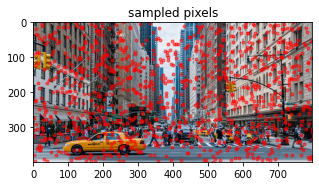

In [8]:
fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(im)
plt.scatter(col_sample, row_sample, c='r',marker='.', alpha=0.5)
plt.title('sampled pixels')
plt.show()

In [9]:
fvec = extractFeatures((row_sample[0], col_sample[0]), im, 8) #window_radius hand-tuned
feature_dim = fvec.shape[0]
feature_vectors = np.zeros((feature_dim, N)) #feature vectors stored as columns
feature_vectors[:,0] = fvec

for p in range(1,N):
    fvec = extractFeatures((row_sample[p], col_sample[p]), im, 8)
    feature_vectors[:,p] = fvec

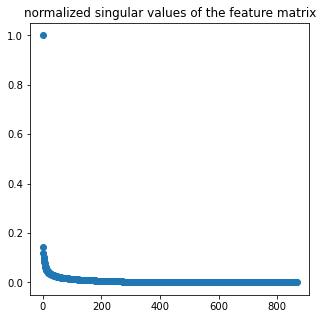

In [10]:
## PCA for dimension reduction in feature space
U, s, Vt = np.linalg.svd(feature_vectors, full_matrices=True)
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(range(len(s)),s/np.max(s))
plt.title('normalized singular values of the feature matrix')
plt.show()

# F = [f1,...,fN] = USV' = $_i s_i u_iv_i'

# min_a ||fi - Ua||^2 = min_a ||[$_j s_j u_j v_j']_i - a||^2
#                   = min_a $_{j=1:n} ( [U*fi]_j - a_j)^2
#                   = min_a $_{j=1:n} ( U_j*fi - a_j)^2

In [11]:
s_cutoff = 12 # if this is too large, we have poor results due to having only N=1000 samples
Ur = U[:,0:s_cutoff]
lowD_feature_vectors = Ur.T @ feature_vectors

In [12]:
# using algorithm 1, this takes quite a bit of time given the algorithm's pairwise combinatorial nature...
epsilon = 1.0
opts={'maxIter': 1e6}
S = pairwiseSteepestDescent(lowD_feature_vectors, epsilon, opts)

In [13]:
#for convenience, we save the result above so we don't need to rerun it.
import pickle
pickle.dump( S, open( "S.pkl", "wb" ) )
pickle.dump( row_sample, open( "row_sample.pkl", "wb" ) )
pickle.dump( col_sample, open( "col_sample.pkl", "wb" ) )
#S = pickle.load( open( "S.pkl", "rb" ) )

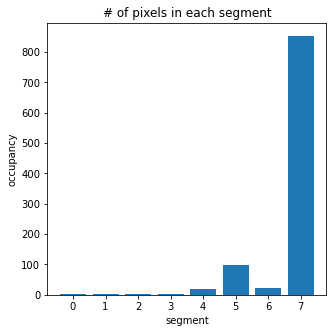

In [15]:
num_seg = len(S)
occupancy = [S[i].shape[1] for i in range(num_seg)]
fig, ax = plt.subplots(figsize=(5,5))
plt.bar(range(num_seg),occupancy)
plt.title('# of pixels in each segment')
plt.xlabel('segment')
plt.ylabel('occupancy')
plt.show()

In [16]:
# Loop through the image pixels. Set the class of a particular pixel to the class of the nearest segment (in feature space).
from tqdm.auto import tqdm

class_key = np.zeros((nrows,ncols), dtype=int)

cutoff = 0 # We only consider adding labels to segments containing > cutoff pixels

for row in tqdm(range(nrows)):
    for col in range(ncols):
        f = extractFeatures((row,col), im, 8)
        f_lowD = Ur.T @ f
        # here we label the pixel (row,col) with the segment that produces minimal group coding
        gcode = np.ones((num_seg,))*np.inf
        for i in range(num_seg):
            if S[i].shape[1] > cutoff:
                S2 = S.copy()
                S2[i] = np.hstack((S2.copy()[i], f_lowD.reshape(-1,1)))
                gcode[i] = groupCodingLength(S2,epsilon)
        
        class_key[row,col] = np.argmin(gcode) #find the class of the nearest segmented sample point

  0%|          | 0/400 [00:00<?, ?it/s]

In [18]:
segmented_im = np.zeros((nrows,ncols, nchannel), dtype=type(im[0,0,0]))

for i in range(num_seg):
    mask = (class_key == i) # the masks for the various classes are orthogonal
    for j in range(nchannel):
        tmp = mask*im[:,:,j] 
        mean_color =  np.mean(tmp[np.nonzero(tmp > 0)])
        segmented_im[:,:,j] = segmented_im[:,:,j]+mask*mean_color

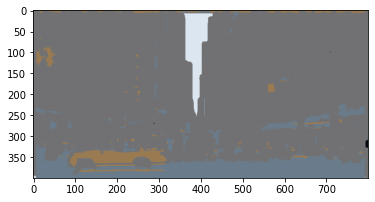

In [19]:
plt.imshow(segmented_im)
plt.show()

While we were able to get great results on the simple toy example, getting good results on real images requires preprocessing of the data, careful choice of feature vectors, and fine-tuning of the algorithm hyperparameters (e.g., $\epsilon$, window-size for feature vectors, PCA cutoff, etc.). The above results were generated after spending some time playing around with $\epsilon$, the window-size, the PCA cutoff, and the number of samples. As the above algorithm becomes expensive to run for many samples, and so we will not seek to improve these results. The point of this script is to implement and illustrate the method and published references, such as the one presented above and the one below, provide additional techniques to improve the fidelity of the algorithm.

__Yang, Allen Y., et al. "Unsupervised segmentation of natural images via lossy data compression." Computer Vision and Image Understanding 110.2 (2008): 212-225.__

We present another somewhat simpler example below:

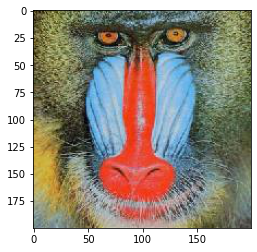

In [4]:
#loading the new image
from matplotlib import image

im = image.imread('mandrill.jpg') / 255
nrows = im.shape[0]
ncols = im.shape[1]
nchannel = im.shape[2]

plt.imshow(im)
plt.show()

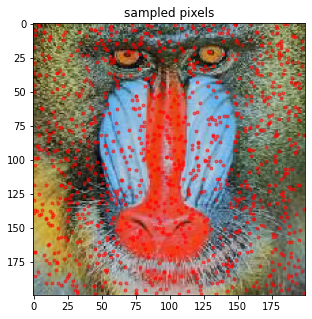

In [5]:
N = 1000 #number of pixels to be sampled
row_sample = np.random.randint(0,nrows,N)
col_sample = np.random.randint(0,ncols,N)

fig, ax = plt.subplots(figsize=(5,5))
plt.imshow(im)
plt.scatter(col_sample, row_sample, c='r',marker='.', alpha=0.5)
plt.title('sampled pixels')
plt.show()

In [11]:
fvec = extractFeatures((row_sample[0], col_sample[0]), im, 4)
feature_dim = fvec.shape[0]
feature_vectors = np.zeros((feature_dim, N)) #feature vectors stored as columns
feature_vectors[:,0] = fvec

for p in range(1,N):
    fvec = extractFeatures((row_sample[p], col_sample[p]), im, 4)
    feature_vectors[:,p] = fvec

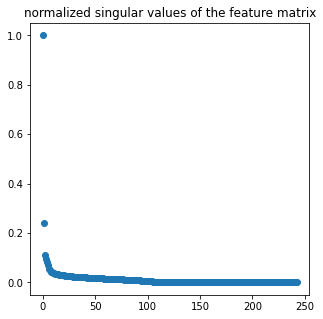

In [12]:
U, s, Vt = np.linalg.svd(feature_vectors, full_matrices=True)
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(range(len(s)),s/np.max(s))
plt.title('normalized singular values of the feature matrix')
plt.show()

In [13]:
s_cutoff = 8 
Ur = U[:,0:s_cutoff]
lowD_feature_vectors = Ur.T @ feature_vectors

In [15]:
epsilon = 1.0
opts={'maxIter': 1e6}
S = pairwiseSteepestDescent(lowD_feature_vectors, epsilon, opts)

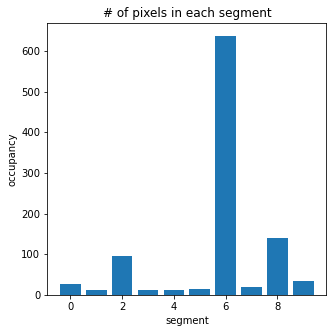

In [16]:
num_seg = len(S)
occupancy = [S[i].shape[1] for i in range(num_seg)]
fig, ax = plt.subplots(figsize=(5,5))
plt.bar(range(num_seg),occupancy)
plt.title('# of pixels in each segment')
plt.xlabel('segment')
plt.ylabel('occupancy')
plt.show()

In [17]:
from tqdm.auto import tqdm
class_key = np.zeros((nrows,ncols), dtype=int)
cutoff = 0 
for row in tqdm(range(nrows)):
    for col in range(ncols):
        f = extractFeatures((row,col), im, 4)
        f_lowD = Ur.T @ f
        # here we label the pixel (row,col) with the segment that produces minimal group coding
        gcode = np.ones((num_seg,))*np.inf
        for i in range(num_seg):
            if S[i].shape[1] > cutoff:
                S2 = S.copy()
                S2[i] = np.hstack((S2.copy()[i], f_lowD.reshape(-1,1)))
                gcode[i] = groupCodingLength(S2,epsilon)
        
        class_key[row,col] = np.argmin(gcode) #find the class of the nearest segmented sample point

  0%|          | 0/200 [00:00<?, ?it/s]

In [18]:
segmented_im = np.zeros((nrows,ncols, nchannel), dtype=type(im[0,0,0]))
for i in range(num_seg):
    mask = (class_key == i) # the masks for the various classes are orthogonal
    for j in range(nchannel):
        tmp = mask*im[:,:,j] 
        mean_color =  np.mean(tmp[np.nonzero(tmp > 0)])
        segmented_im[:,:,j] = segmented_im[:,:,j]+mask*mean_color

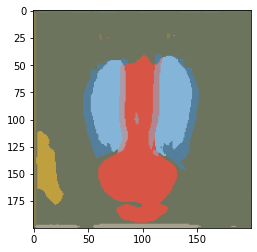

In [19]:
plt.imshow(segmented_im)
plt.show()

Interestingly, the eyes are not segmented well. Perhaps we need more samples?